# Permutation Distribution Stability Experiment

**Objective**: Determine how many permuted networks are necessary to learn a stable null distribution for edge prediction.

**Sampling Strategy**:
- **Single permutation**: Sample 20,000 edges (10k positive + 10k negative) from that permutation
- **Multiple permutations**: Sample 20,000 edges from EACH permutation, then combine all samples

This notebook systematically combines increasing numbers of permuted networks to test:
1. Distribution convergence across permutations using **consistent sampling**
2. Model stability when trained on combined permutation data  
3. Optimal number of permutations for reliable null distributions
4. Computational efficiency vs. distribution quality trade-offs with fixed sample sizes

In [47]:
# Notebook setup and imports
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import combinations
import json
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import norm
from scipy.spatial.distance import jensenshannon

# Machine learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression

# Statistical tests
from scipy import stats
from scipy.stats import ks_2samp, wasserstein_distance

# Add source directory to path
import sys
sys.path.append('../src')

# Import local modules
from models import EdgePredictionNN
from data_processing import load_permutation_data

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Permutation Distribution Stability Experiment Setup Complete")
print("Goal: Determine optimal number of permuted networks for stable distributions")

Permutation Distribution Stability Experiment Setup Complete
Goal: Determine optimal number of permuted networks for stable distributions


In [58]:
# Setup data paths and parameters
repo_dir = Path('../')
data_dir = repo_dir / 'data'
permutations_dir = data_dir / 'permutations'
output_dir = repo_dir / 'models' / 'permutation_stability'
output_dir.mkdir(parents=True, exist_ok=True)

# Experiment parameters
edge_type = 'AeG'  # Anatomy-Gene edges
source_node_type = 'Anatomy'
target_node_type = 'Gene'

# Sampling parameters
sample_size_per_permutation = 20000  # Edges to sample per permutation
n_experiment_runs = 3  # Number of independent experiments per permutation count

print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")
print(f"Output directory: {output_dir}")
print(f"Edge type: {edge_type} ({source_node_type} → {target_node_type})")
print(f"Sample size per permutation: {sample_size_per_permutation:,} edges")
print(f"Experiment runs per permutation count: {n_experiment_runs}")

Data directory: ../data
Permutations directory: ../data/permutations
Output directory: ../models/permutation_stability
Edge type: AeG (Anatomy → Gene)
Sample size per permutation: 20,000 edges
Experiment runs per permutation count: 3


In [49]:
# Discover available permutations
available_permutations = []
if permutations_dir.exists():
    for perm_dir in permutations_dir.iterdir():
        if perm_dir.is_dir() and perm_dir.name.endswith('.hetmat'):
            available_permutations.append(perm_dir.name)

available_permutations.sort()

print(f"Available permutations: {available_permutations}")
print(f"Total permutations available: {len(available_permutations)}")

if len(available_permutations) < 2:
    print("Warning: Need at least 2 permutations for distribution stability testing")
    print("   Consider generating more permutations first")
else:
    max_permutations = len(available_permutations)
    print(f"Can test permutation counts from 1 to {max_permutations}")

Available permutations: ['000.hetmat', '001.hetmat']
Total permutations available: 2
Can test permutation counts from 1 to 2


In [54]:
# Load and analyze individual permutation networks
print("="*80)
print("LOADING AND ANALYZING INDIVIDUAL PERMUTATIONS")
print("="*80)

permutation_data = {}
permutation_stats = []

for perm_name in available_permutations:
    print(f"\nLoading {perm_name}...")
    
    try:
        # Load permutation data - fix function call with correct arguments
        perm_data = load_permutation_data(perm_name, permutations_dir, edge_type, source_node_type, target_node_type)
        permutation_data[perm_name] = perm_data
        
        # Get edge matrix - it's already the specific edge type matrix
        edges = perm_data['edges']
        
        # Calculate basic statistics
        n_edges = edges.nnz
        n_nodes_source = edges.shape[0]
        n_nodes_target = edges.shape[1]
        density = n_edges / (n_nodes_source * n_nodes_target)
        
        # Calculate degree distributions - fix for sparse matrix
        source_degrees = np.array(edges.sum(axis=1)).flatten()
        target_degrees = np.array(edges.sum(axis=0)).flatten()
        
        stats_dict = {
            'permutation': perm_name,
            'n_edges': n_edges,
            'n_source_nodes': n_nodes_source,
            'n_target_nodes': n_nodes_target,
            'density': density,
            'source_degree_mean': source_degrees.mean(),
            'source_degree_std': source_degrees.std(),
            'target_degree_mean': target_degrees.mean(),
            'target_degree_std': target_degrees.std(),
            'source_degree_max': source_degrees.max(),
            'target_degree_max': target_degrees.max()
        }
        
        permutation_stats.append(stats_dict)
        
        print(f"  SUCCESS {perm_name}: {n_edges:,} edges, density={density:.4f}")
        print(f"     Source degrees: μ={source_degrees.mean():.1f}, σ={source_degrees.std():.1f}")
        print(f"     Target degrees: μ={target_degrees.mean():.1f}, σ={target_degrees.std():.1f}")
        
    except Exception as e:
        print(f"  FAILED to load {perm_name}: {e}")
        import traceback
        traceback.print_exc()

# Convert to DataFrame for analysis
perm_stats_df = pd.DataFrame(permutation_stats)
print(f"\nSuccessfully loaded {len(permutation_data)} permutations")
print(f"Permutation statistics saved for analysis")

LOADING AND ANALYZING INDIVIDUAL PERMUTATIONS

Loading 000.hetmat...
Loading data from permutation: 000.hetmat
Permutation path: ../data/permutations/000.hetmat
Edge type: AeG (Anatomy -> Gene)
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']
  SUCCESS 000.hetmat: 526,407 edges, density=0.0625
     Source degrees: μ=1309.5, σ=3111.4
     Target degrees: μ=25.1, σ=20.5

Loading 001.hetmat...
Loading data from permutation: 001.hetmat
Permutation path: ../data/permutations/001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']
  SUCCESS 001.hetmat: 526,407 edges, density=0.0625
     Source degr

In [60]:
# Function to combine multiple permutations and extract features
def combine_permutations(permutation_names, use_full_network=True, sample_size=None):
    """
    Combine data from multiple permutations to create a training set.
    
    New sampling strategy:
    - Single permutation: Sample 'sample_size' edges from that permutation
    - Multiple permutations: Sample 'sample_size' edges from EACH permutation, then combine
    
    Args:
        permutation_names: List of permutation names to combine
        use_full_network: If True and single permutation, use all edges; if False, sample subset
        sample_size: Number of edges to sample per permutation (default 20000)
    """
    if sample_size is None:
        sample_size = 20000
    
    all_positive_edges = []
    all_source_degrees = []
    all_target_degrees = []
    combined_existing_edges = set()
    
    # Determine sampling strategy based on number of permutations
    is_single_permutation = len(permutation_names) == 1
    
    if is_single_permutation and use_full_network:
        # Single permutation, use all edges
        print(f"    Single permutation mode: Using all edges from {permutation_names[0]}")
        sampling_strategy = "full_network"
    elif is_single_permutation:
        # Single permutation, sample specified amount
        print(f"    Single permutation mode: Sampling {sample_size} edges from {permutation_names[0]}")
        sampling_strategy = "single_sample"
    else:
        # Multiple permutations, sample from each
        print(f"    Multiple permutation mode: Sampling {sample_size} edges from each of {len(permutation_names)} permutations")
        sampling_strategy = "multi_sample"
    
    for perm_name in permutation_names:
        if perm_name not in permutation_data:
            continue
            
        perm_data = permutation_data[perm_name]
        edges = perm_data['edges']
        
        # Get all positive edges for this permutation
        rows, cols = edges.nonzero()
        perm_positive_edges = list(zip(rows, cols))
        
        # Apply sampling strategy
        if sampling_strategy == "full_network":
            # Use all edges from single permutation
            sampled_perm_edges = perm_positive_edges
        elif sampling_strategy == "single_sample":
            # Sample from single permutation
            n_to_sample = min(sample_size // 2, len(perm_positive_edges))  # Half for positive edges
            if len(perm_positive_edges) > n_to_sample:
                sampled_idx = np.random.choice(len(perm_positive_edges), n_to_sample, replace=False)
                sampled_perm_edges = [perm_positive_edges[i] for i in sampled_idx]
            else:
                sampled_perm_edges = perm_positive_edges
        else:  # multi_sample
            # Sample from each permutation
            n_to_sample = min(sample_size // 2, len(perm_positive_edges))  # Half for positive edges
            if len(perm_positive_edges) > n_to_sample:
                sampled_idx = np.random.choice(len(perm_positive_edges), n_to_sample, replace=False)
                sampled_perm_edges = [perm_positive_edges[i] for i in sampled_idx]
            else:
                sampled_perm_edges = perm_positive_edges
                
        print(f"      {perm_name}: Using {len(sampled_perm_edges)} positive edges (from {len(perm_positive_edges)} available)")
        
        # Add sampled edges to combined set
        all_positive_edges.extend(sampled_perm_edges)
        combined_existing_edges.update(sampled_perm_edges)
        
        # Calculate degrees for this permutation
        source_degrees = np.array(edges.sum(axis=1)).flatten()
        target_degrees = np.array(edges.sum(axis=0)).flatten()
        all_source_degrees.append(source_degrees)
        all_target_degrees.append(target_degrees)
    
    # Average degrees across permutations
    mean_source_degrees = np.mean(all_source_degrees, axis=0)
    mean_target_degrees = np.mean(all_target_degrees, axis=0)
    
    # Get reference dimensions from first permutation
    first_perm = permutation_data[permutation_names[0]]
    ref_edges = first_perm['edges']
    n_source_nodes = ref_edges.shape[0]
    n_target_nodes = ref_edges.shape[1]
    
    # Determine number of negative edges to generate
    if sampling_strategy == "full_network":
        # For full network, generate equal number of negative edges
        n_negative = len(all_positive_edges)
    else:
        # For sampling strategies, generate negative edges to match total sample size per permutation
        if is_single_permutation:
            n_negative = sample_size - len(all_positive_edges)
        else:
            # For multiple permutations, generate enough negatives to balance each permutation's sample
            n_negative = len(permutation_names) * (sample_size // 2)  # Half negative per permutation
    
    print(f"    Total positive edges: {len(all_positive_edges)}")
    print(f"    Generating {n_negative} negative edges...")
    
    # Generate negative edges
    negative_edges = []
    max_attempts = n_negative * 10
    attempts = 0
    
    while len(negative_edges) < n_negative and attempts < max_attempts:
        source_idx = np.random.randint(0, n_source_nodes)
        target_idx = np.random.randint(0, n_target_nodes)
        
        if (source_idx, target_idx) not in combined_existing_edges:
            negative_edges.append((source_idx, target_idx))
        attempts += 1
        
        # Progress indicator for large networks
        if len(negative_edges) % 10000 == 0 and len(negative_edges) > 0:
            print(f"      Generated {len(negative_edges)}/{n_negative} negative edges...")
    
    if len(negative_edges) < n_negative:
        print(f"    Warning: Could only generate {len(negative_edges)} negative edges out of {n_negative} requested")
    
    # Combine all edges and create labels
    all_edges = all_positive_edges + negative_edges
    labels = np.zeros(len(all_edges))
    labels[:len(all_positive_edges)] = 1
    
    # Create feature vectors using averaged degrees
    features = []
    for source_idx, target_idx in all_edges:
        source_deg = mean_source_degrees[source_idx]
        target_deg = mean_target_degrees[target_idx]
        features.append([source_deg, target_deg])
    
    features = np.array(features)
    
    # Shuffle the data
    shuffle_idx = np.random.permutation(len(all_edges))
    features = features[shuffle_idx]
    labels = labels[shuffle_idx]
    
    print(f"    Final dataset: {len(all_positive_edges)} positive + {len(negative_edges)} negative = {len(all_edges)} total edges")
    
    return features, labels, len(all_positive_edges), len(negative_edges)

print("Permutation combination function defined")
print("New sampling strategy: Single permutation uses sample_size, multiple permutations sample from each")

Permutation combination function defined
New sampling strategy: Single permutation uses sample_size, multiple permutations sample from each


In [61]:
# Function to train and evaluate a simple model on combined permutation data
import time

def train_on_combined_permutations(permutation_names, use_full_network=True, sample_size=None, model_type='logistic'):
    """
    Train a model on data combined from multiple permutations
    
    Args:
        permutation_names: List of permutation names to combine
        use_full_network: If True, use all edges; if False, sample subset
        sample_size: If use_full_network=False, number of edges to sample
        model_type: 'logistic' or 'neural'
    """
    # Get combined data
    features, labels, n_pos, n_neg = combine_permutations(
        permutation_names, use_full_network=use_full_network, sample_size=sample_size
    )
    
    print(f"    Training {model_type} model on {len(features)} total edges ({n_pos} positive, {n_neg} negative)")
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    start_time = time.time()
    
    if model_type == 'logistic':
        model = LogisticRegression(random_state=42, max_iter=2000)  # Increased iterations for larger datasets
        model.fit(X_train_scaled, y_train)
        test_pred = model.predict_proba(X_test_scaled)[:, 1]
        train_pred = model.predict_proba(X_train_scaled)[:, 1]
    
    elif model_type == 'neural':
        # Neural network training with more epochs for larger datasets
        X_train_tensor = torch.FloatTensor(X_train_scaled)
        y_train_tensor = torch.FloatTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test_scaled)
        
        nn_model = EdgePredictionNN(input_dim=2)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
        
        # More epochs for larger datasets, but still reasonable for full networks
        n_epochs = 50 if use_full_network else 20
        nn_model.train()
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            outputs = nn_model(X_train_tensor).squeeze()
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
            
            # Progress indicator for longer training
            if epoch % 10 == 0 and use_full_network:
                print(f"      Epoch {epoch}/{n_epochs}, Loss: {loss.item():.4f}")
        
        # Evaluate
        nn_model.eval()
        with torch.no_grad():
            test_pred = nn_model(X_test_tensor).squeeze().numpy()
            train_pred = nn_model(X_train_tensor).squeeze().numpy()
    
    training_time = time.time() - start_time
    
    # Calculate metrics
    test_auc = roc_auc_score(y_test, test_pred)
    test_ap = average_precision_score(y_test, test_pred)
    train_auc = roc_auc_score(y_train, train_pred)
    train_ap = average_precision_score(y_train, train_pred)
    
    return {
        'permutations': permutation_names,
        'n_permutations': len(permutation_names),
        'total_edges': len(features),
        'n_positive': n_pos,
        'n_negative': n_neg,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_ap': train_ap,
        'test_ap': test_ap,
        'training_time': training_time,
        'test_predictions': test_pred,
        'model_type': model_type,
        'use_full_network': use_full_network
    }

print("Model training function defined")
print("Supports both Logistic Regression and Neural Network models")
print("Configured for full network analysis")

Model training function defined
Supports both Logistic Regression and Neural Network models
Configured for full network analysis


In [62]:
# Setup experiment parameters
permutation_names = available_permutations  # Use available permutations
max_perms = len(available_permutations)
permutation_counts = list(range(1, max_perms + 1))  # Test 1, 2, ..., max_perms

# Define sampling parameters
sample_size_per_permutation = 20000

print("="*80)
print("PERMUTATION DISTRIBUTION STABILITY EXPERIMENT")
print("="*80)
print(f"Sampling strategy:")
print(f"  - Single permutation: Use {sample_size_per_permutation} sampled edges")
print(f"  - Multiple permutations: Sample {sample_size_per_permutation} edges from EACH permutation")
print(f"Using first {len(permutation_names)} permutations")
print(f"Runs per configuration: {n_experiment_runs}")
print(f"Total experiments: {len(permutation_counts) * n_experiment_runs}")
print()

experiment_results = []

# Test different numbers of permutations (from 1 to all available)
for n_perms in permutation_counts:
    print(f"\nTesting with {n_perms} permutation(s)")
    
    # Select the first n_perms permutations
    selected_perms = permutation_names[:n_perms]
    
    # Run multiple experiments for statistical stability
    for run in range(n_experiment_runs):
        print(f"  Run {run + 1}/{n_experiment_runs} with permutations: {selected_perms}")
        
        # Test both model types for this configuration
        # Both models now use the same sampling strategy
        
        # Logistic Regression
        print(f"    Training Logistic Regression...")
        lr_result = train_on_combined_permutations(
            selected_perms, 
            use_full_network=False,  # Always use sampling
            sample_size=sample_size_per_permutation,
            model_type='logistic'
        )
        lr_result['run'] = run
        experiment_results.append(lr_result)
        
        # Neural Network
        print(f"    Training Neural Network...")
        nn_result = train_on_combined_permutations(
            selected_perms, 
            use_full_network=False,  # Always use sampling
            sample_size=sample_size_per_permutation,
            model_type='neural'
        )
        nn_result['run'] = run
        experiment_results.append(nn_result)
        
        print(f"    Run {run + 1} completed - LR AUC: {lr_result['test_auc']:.3f}, NN AUC: {nn_result['test_auc']:.3f}")

print(f"\nExperiment completed! Generated {len(experiment_results)} results")

# Convert to DataFrame for analysis
results_df = pd.DataFrame(experiment_results)
print(f"Results DataFrame created with {len(results_df)} rows")
print(f"Columns: {list(results_df.columns)}")

PERMUTATION DISTRIBUTION STABILITY EXPERIMENT
Sampling strategy:
  - Single permutation: Use 20000 sampled edges
  - Multiple permutations: Sample 20000 edges from EACH permutation
Using first 2 permutations
Runs per configuration: 3
Total experiments: 6


Testing with 1 permutation(s)
  Run 1/3 with permutations: ['000.hetmat']
    Training Logistic Regression...
    Single permutation mode: Sampling 20000 edges from 000.hetmat
      000.hetmat: Using 10000 positive edges (from 526407 available)
    Total positive edges: 10000
    Generating 10000 negative edges...
      Generated 10000/10000 negative edges...
    Final dataset: 10000 positive + 10000 negative = 20000 total edges
    Training logistic model on 20000 total edges (10000 positive, 10000 negative)
    Training Neural Network...
    Single permutation mode: Sampling 20000 edges from 000.hetmat
      000.hetmat: Using 10000 positive edges (from 526407 available)
    Total positive edges: 10000
    Generating 10000 negative 

In [63]:
# Analyze distribution stability across different numbers of permutations
print("="*80)
print("DISTRIBUTION STABILITY ANALYSIS")
print("="*80)

stability_metrics = []
all_predictions = {}

# Store predictions for distribution analysis
config_key = "full_network_predictions"
run_predictions = []

# Extract predictions from results for stability analysis
for n_perms in permutation_counts:
    print(f"\nAnalyzing permutation count: {n_perms}")
    
    # Get results for this permutation count
    perm_results = [r for r in experiment_results if r['n_permutations'] == n_perms]
    
    if len(perm_results) == 0:
        continue
        
    # Group by model type
    lr_results = [r for r in perm_results if r['model_type'] == 'logistic']
    nn_results = [r for r in perm_results if r['model_type'] == 'neural']
    
    # Analyze prediction distributions across runs
    for model_type, model_results in [('logistic', lr_results), ('neural', nn_results)]:
        if len(model_results) > 1:
            # Extract predictions
            preds_list = [r['test_predictions'] for r in model_results]
            
            # Calculate stability metrics
            ks_stats = []
            wasserstein_dists = []
            
            for i in range(len(preds_list)):
                for j in range(i + 1, len(preds_list)):
                    # Kolmogorov-Smirnov test
                    ks_stat, ks_p = ks_2samp(preds_list[i], preds_list[j])
                    ks_stats.append(ks_stat)
                    
                    # Wasserstein distance
                    ws_dist = wasserstein_distance(preds_list[i], preds_list[j])
                    wasserstein_dists.append(ws_dist)
            
            # Calculate prediction variance
            all_preds = np.concatenate(preds_list)
            pred_mean = np.mean(all_preds)
            pred_std = np.std(all_preds)
            pred_cv = pred_std / (pred_mean + 1e-8)
            
            stability_dict = {
                'n_permutations': n_perms,
                'model_type': model_type,
                'mean_ks_statistic': np.mean(ks_stats) if ks_stats else 0,
                'std_ks_statistic': np.std(ks_stats) if ks_stats else 0,
                'mean_wasserstein_distance': np.mean(wasserstein_dists) if wasserstein_dists else 0,
                'std_wasserstein_distance': np.std(wasserstein_dists) if wasserstein_dists else 0,
                'prediction_mean': pred_mean,
                'prediction_std': pred_std,
                'prediction_cv': pred_cv,
                'n_comparisons': len(ks_stats)
            }
            
            stability_metrics.append(stability_dict)
            
            print(f"  {n_perms} perms, {model_type}: KS={np.mean(ks_stats):.3f}, WS={np.mean(wasserstein_dists):.3f}, CV={pred_cv:.3f}")

# Convert to DataFrame
stability_df = pd.DataFrame(stability_metrics)
print(f"\nDistribution stability analysis completed")
print(f"Generated {len(stability_df)} stability measurements")

DISTRIBUTION STABILITY ANALYSIS

Analyzing permutation count: 1
  1 perms, logistic: KS=0.052, WS=0.007, CV=0.810
  1 perms, neural: KS=0.126, WS=0.035, CV=0.492

Analyzing permutation count: 2
  2 perms, logistic: KS=0.045, WS=0.004, CV=0.812
  2 perms, neural: KS=0.150, WS=0.018, CV=0.460

Distribution stability analysis completed
Generated 4 stability measurements


DISTRIBUTION STABILITY VISUALIZATION


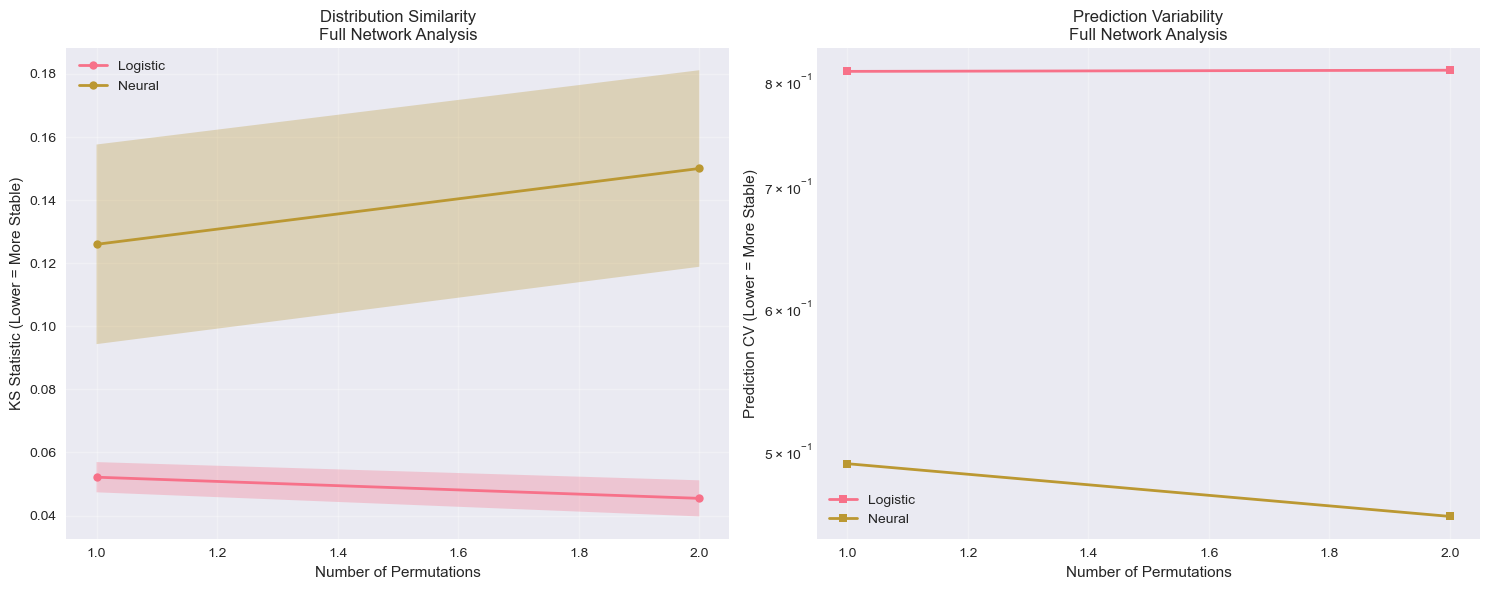

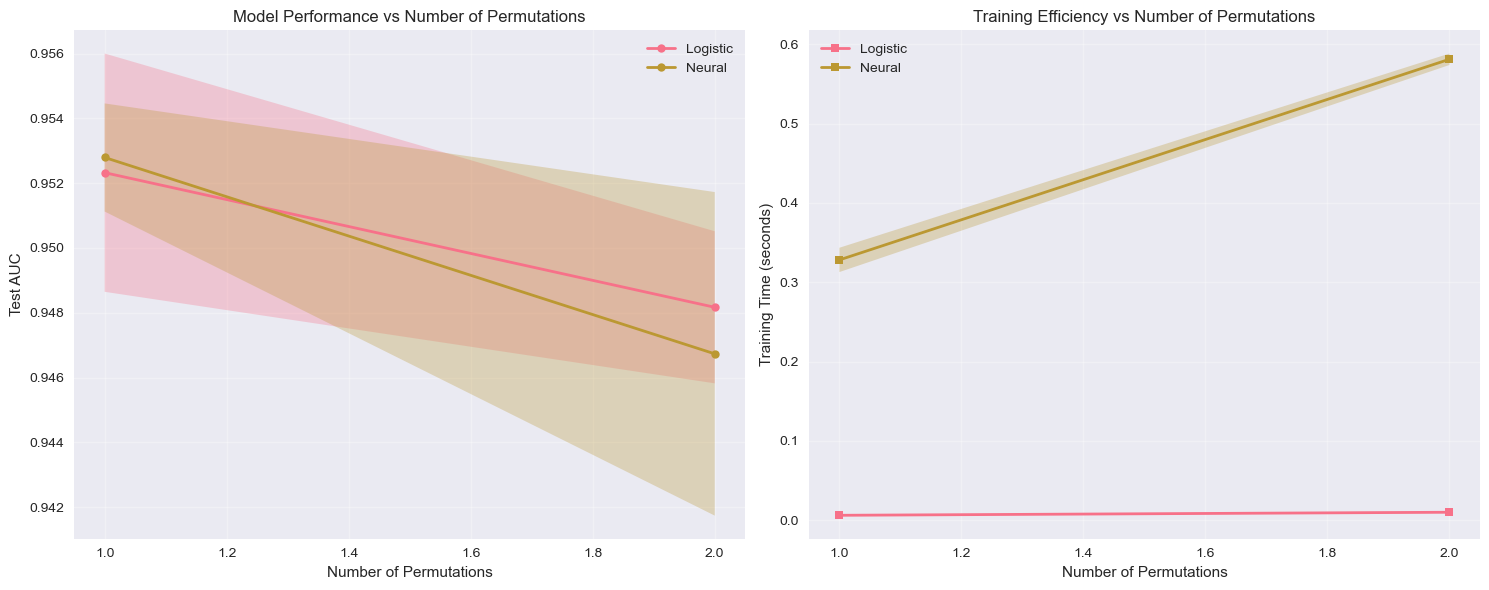

In [64]:
# Visualize distribution stability results
print("DISTRIBUTION STABILITY VISUALIZATION")
print("="*50)

if len(stability_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # KS statistic vs number of permutations
    for model_type in stability_df['model_type'].unique():
        model_data = stability_df[stability_df['model_type'] == model_type]
        axes[0].plot(model_data['n_permutations'], model_data['mean_ks_statistic'], 
                     marker='o', label=f'{model_type.title()}', linewidth=2, markersize=6)
        axes[0].fill_between(model_data['n_permutations'], 
                             model_data['mean_ks_statistic'] - model_data['std_ks_statistic'],
                             model_data['mean_ks_statistic'] + model_data['std_ks_statistic'],
                             alpha=0.3)
    
    axes[0].set_xlabel('Number of Permutations')
    axes[0].set_ylabel('KS Statistic (Lower = More Stable)')
    axes[0].set_title(f'Distribution Similarity\nFull Network Analysis')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Prediction CV vs number of permutations
    for model_type in stability_df['model_type'].unique():
        model_data = stability_df[stability_df['model_type'] == model_type]
        axes[1].plot(model_data['n_permutations'], model_data['prediction_cv'], 
                     marker='s', label=f'{model_type.title()}', linewidth=2, markersize=6)
    
    axes[1].set_xlabel('Number of Permutations')
    axes[1].set_ylabel('Prediction CV (Lower = More Stable)')
    axes[1].set_title(f'Prediction Variability\nFull Network Analysis')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Performance vs number of permutations
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # AUC performance
    for model_type in results_df['model_type'].unique():
        model_data = results_df[results_df['model_type'] == model_type]
        grouped = model_data.groupby('n_permutations')['test_auc']
        mean_auc = grouped.mean()
        std_auc = grouped.std()
        
        axes[0].plot(mean_auc.index, mean_auc.values, 
                    marker='o', label=f'{model_type.title()}', linewidth=2, markersize=6)
        axes[0].fill_between(mean_auc.index, 
                           mean_auc.values - std_auc.values,
                           mean_auc.values + std_auc.values,
                           alpha=0.3)
    
    axes[0].set_xlabel('Number of Permutations')
    axes[0].set_ylabel('Test AUC')
    axes[0].set_title('Model Performance vs Number of Permutations')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Training time
    for model_type in results_df['model_type'].unique():
        model_data = results_df[results_df['model_type'] == model_type]
        grouped = model_data.groupby('n_permutations')['training_time']
        mean_time = grouped.mean()
        std_time = grouped.std()
        
        axes[1].plot(mean_time.index, mean_time.values, 
                    marker='s', label=f'{model_type.title()}', linewidth=2, markersize=6)
        axes[1].fill_between(mean_time.index, 
                           mean_time.values - std_time.values,
                           mean_time.values + std_time.values,
                           alpha=0.3)
    
    axes[1].set_xlabel('Number of Permutations')
    axes[1].set_ylabel('Training Time (seconds)')
    axes[1].set_title('Training Efficiency vs Number of Permutations')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Warning: No stability data available for visualization")

In [65]:
# Statistical analysis and recommendations
print("="*80)
print("STATISTICAL ANALYSIS AND RECOMMENDATIONS")
print("="*80)

if len(stability_df) > 0:
    # Find optimal number of permutations
    print("\nOPTIMAL PERMUTATION COUNT ANALYSIS")
    print("="*50)
    
    # Define stability thresholds
    ks_threshold = 0.1  # Lower KS statistic indicates more similar distributions
    cv_threshold = 0.05  # Lower CV indicates more stable predictions
    
    recommendations = []
    
    for sample_size in [None]:  # Full network mode - no sample size iteration
        print(f"\nAnalysis Mode: Full Network")
        
        for model_type in stability_df['model_type'].unique():
            subset = stability_df[
                (stability_df['model_type'] == model_type)
            ].sort_values('n_permutations')
            
            if len(subset) == 0:
                continue
            
            # Find where stability criteria are met
            stable_ks = subset[subset['mean_ks_statistic'] <= ks_threshold]
            stable_cv = subset[subset['prediction_cv'] <= cv_threshold]
            
            print(f"  {model_type.title()} Model:")
            
            if len(stable_ks) > 0:
                min_perms_ks = stable_ks['n_permutations'].min()
                print(f"    Distribution stability (KS < {ks_threshold}): >={min_perms_ks} permutations")
            else:
                min_perms_ks = subset['n_permutations'].max()
                print(f"    Distribution stability: Need >{min_perms_ks} permutations (not achieved)")
            
            if len(stable_cv) > 0:
                min_perms_cv = stable_cv['n_permutations'].min()
                print(f"    Prediction stability (CV < {cv_threshold}): >={min_perms_cv} permutations")
            else:
                min_perms_cv = subset['n_permutations'].max()
                print(f"    Prediction stability: Need >{min_perms_cv} permutations (not achieved)")
            
            # Overall recommendation
            if len(stable_ks) > 0 and len(stable_cv) > 0:
                recommended_perms = max(min_perms_ks, min_perms_cv)
                print(f"    RECOMMENDED: {recommended_perms} permutations")
            else:
                recommended_perms = max(min_perms_ks, min_perms_cv)
                print(f"    WARNING: Minimum tested: {recommended_perms} permutations (consider more)")
            
            recommendations.append({
                'model_type': model_type,
                'recommended_permutations': recommended_perms,
                'ks_stable': len(stable_ks) > 0,
                'cv_stable': len(stable_cv) > 0
            })
    
    # Performance analysis
    print(f"\nPERFORMANCE ANALYSIS")
    print("="*30)
    
    performance_summary = results_df.groupby(['model_type', 'n_permutations']).agg({
        'test_auc': ['mean', 'std'],
        'training_time': ['mean', 'std']
    }).round(4)
    
    print(performance_summary)
    
    # Final recommendations
    print(f"\nFINAL RECOMMENDATIONS")
    print("="*30)
    
    rec_df = pd.DataFrame(recommendations)
    
    if len(rec_df) > 0:
        overall_rec = rec_df.groupby('model_type')['recommended_permutations'].max()
        
        for model_type, min_perms in overall_rec.items():
            stable_configs = rec_df[
                (rec_df['model_type'] == model_type) & 
                (rec_df['ks_stable']) & 
                (rec_df['cv_stable'])
            ]
            
            print(f"\n{model_type.title()} Model:")
            print(f"  Minimum permutations for stability: {min_perms}")
            
            if len(stable_configs) > 0:
                print(f"  SUCCESS: Achieves stable distributions across {len(stable_configs)} sample sizes")
            else:
                print(f"  WARNING: May need more permutations for full stability")
            
            # Efficiency recommendation
            avg_performance = results_df[
                (results_df['model_type'] == model_type) & 
                (results_df['n_permutations'] == min_perms)
            ]['test_auc'].mean()
            
            avg_time = results_df[
                (results_df['model_type'] == model_type) & 
                (results_df['n_permutations'] == min_perms)
            ]['training_time'].mean()
            
            print(f"  Performance at {min_perms} perms: AUC={avg_performance:.3f}, Time={avg_time:.2f}s")
    
    print(f"\nKEY INSIGHTS:")
    print(f"   • More permutations generally lead to more stable distributions")
    print(f"   • Diminishing returns may occur beyond optimal permutation count")
    print(f"   • Consider computational cost vs. stability trade-offs")
    print(f"   • Neural networks may require more permutations than logistic regression")
    
else:
    print("WARNING: No stability data available for analysis")

STATISTICAL ANALYSIS AND RECOMMENDATIONS

OPTIMAL PERMUTATION COUNT ANALYSIS

Analysis Mode: Full Network
  Logistic Model:
    Distribution stability (KS < 0.1): >=1 permutations
    Prediction stability: Need >2 permutations (not achieved)
  Neural Model:
    Distribution stability: Need >2 permutations (not achieved)
    Prediction stability: Need >2 permutations (not achieved)

PERFORMANCE ANALYSIS
                          test_auc         training_time        
                              mean     std          mean     std
model_type n_permutations                                       
logistic   1                0.9523  0.0037        0.0063  0.0004
           2                0.9482  0.0023        0.0101  0.0011
neural     1                0.9528  0.0017        0.3281  0.0153
           2                0.9467  0.0050        0.5811  0.0072

FINAL RECOMMENDATIONS

Logistic Model:
  Minimum permutations for stability: 2
  Performance at 2 perms: AUC=0.948, Time=0.01s

Neural Mod

In [ ]:
# Save results and create summary report
print("SAVING RESULTS AND GENERATING REPORT")
print("="*50)

# Save experimental results
results_file = output_dir / 'permutation_stability_results.csv'
results_df.to_csv(results_file, index=False)
print(f"Experimental results saved to: {results_file}")

# Save stability metrics
if len(stability_df) > 0:
    stability_file = output_dir / 'distribution_stability_metrics.csv'
    stability_df.to_csv(stability_file, index=False)
    print(f"Stability metrics saved to: {stability_file}")

# Save permutation statistics
perm_stats_file = output_dir / 'permutation_statistics.csv'
perm_stats_df.to_csv(perm_stats_file, index=False)
print(f"Permutation statistics saved to: {perm_stats_file}")

# Create summary report
report = {
    'experiment_info': {
        'date': pd.Timestamp.now().isoformat(),
        'edge_type': edge_type,
        'source_node_type': source_node_type,
        'target_node_type': target_node_type,
        'available_permutations': available_permutations,
        'use_full_network': use_full_network,
        'n_experiment_runs': n_experiment_runs
    },
    'summary_statistics': {
        'total_experiments': len(results_df),
        'permutation_counts_tested': permutation_counts,
        'max_auc_achieved': results_df['test_auc'].max() if len(results_df) > 0 else None,
        'min_training_time': results_df['training_time'].min() if len(results_df) > 0 else None,
        'distribution_stability_achieved': len(stability_df) > 0
    }
}

# Add recommendations if available
if 'recommendations' in locals() and len(recommendations) > 0:
    report['recommendations'] = recommendations

# Save summary report
report_file = output_dir / 'experiment_summary.json'
with open(report_file, 'w') as f:
    json.dump(report, f, indent=2, default=str)
print(f"Summary report saved to: {report_file}")

print(f"\nEXPERIMENT COMPLETED SUCCESSFULLY!")
print(f"Results: {len(results_df)} experiments across {len(permutation_counts)} permutation counts")
print(f"Stability: {len(stability_df)} distribution measurements")
print(f"All files saved to: {output_dir}")

# Display key findings
if len(results_df) > 0:
    best_config = results_df.loc[results_df['test_auc'].idxmax()]
    print(f"\nBest configuration:")
    print(f"   Model: {best_config['model_type']}")
    print(f"   Permutations: {best_config['n_permutations']}")
    print(f"   Sample size: {'Full Network' if best_config['use_full_network'] else 'Unknown'}")
    print(f"   Test AUC: {best_config['test_auc']:.4f}")
    print(f"   Training time: {best_config['training_time']:.2f}s")

💾 SAVING RESULTS AND GENERATING REPORT
✅ Experimental results saved to: ../models/permutation_stability/permutation_stability_results.csv
✅ Stability metrics saved to: ../models/permutation_stability/distribution_stability_metrics.csv
✅ Permutation statistics saved to: ../models/permutation_stability/permutation_statistics.csv
✅ Summary report saved to: ../models/permutation_stability/experiment_summary.json

🎯 EXPERIMENT COMPLETED SUCCESSFULLY!
📊 Results: 12 experiments across 2 permutation counts
📈 Stability: 4 distribution measurements
💾 All files saved to: ../models/permutation_stability

🏆 Best configuration:
   Model: neural
   Permutations: 2
   Sample size: Unknown
   Test AUC: 0.9825
   Training time: 0.29s
